### [MTA_Subway_Trains_Delayed__Beginning_2020_20241117.csv](https://data.ny.gov/Transportation/MTA-Subway-Trains-Delayed-Beginning-2020/wx2t-qtaz/about_data)
Columns: 
- __month__: The month in which subway trains delayed is being calculated (yyyy-mm-dd).
- __division__: The A Division (numbered subway lines), B Division (lettered subway lines) and systemwide.
- __line__: Each subway line (1, 2, 3, 4, 5, 6, 7, A, C, E, B, D, F, M, G, J, Z, L, N, Q, R, W, S 42nd, S Rock, S Fkln).
- __day_type__: Represents weekday as 1 and weekend as 2.
- __reporting_category__: The six categories that delays are reported under: Infrastructure & equipment, Crew availability, Police & medical, External Factors, Operating conditions, Planned ROW work. 
- __subcategory__: The sub-categories that fall under the definition of Delays: Braking; Door-Related; Fire, Smoke, Debris; Inclement Weather; Crew Availability; Insufficient Supplement Schedule; Propulsion; Public Conduct, Crime, Police Response; Rail and Roadbed; Persons on Roadbed; Service Delivery; Sick/Injured Customer; Train Brake Activation - Cause Unknown; Subways Maintenance; Work Equipment; Capital Work - Other Planned ROW; External Debris on Roadbed; External Agency or Utility; Capital Work - Other Planned ROW; Other – CE; Other – Sig; Other Infrastructure; Other Internal Disruptions.
- __delays__: The number of train delays per category and time period.

### [MTA Subway Customer Journey-Focused Metrics: Beginning 2020](https://data.ny.gov/Transportation/MTA-Subway-Customer-Journey-Focused-Metrics-Beginn/4apg-4kt9/about_data)
- __month__: The month in which the metrics are being calculated (yyyy-mm-dd).

- __division__: The A Division (numbered subway lines and S 42nd) and B Division (lettered subway lines).

- __line__: Each subway line (1, 2, 3, 4, 5, 6, 7, A, C, E, B, D, F, M, G, JZ, L, N, Q, R, W, S 42nd, S Rock, S Fkln). A systemwide row also exists for each month in the dataset.

- __period__: Represents both the peak and off-peak service periods.

- __num_passengers__: Total number of passengers reported each month and on each line.

- __additional platform time__: The average additional time in minutes (above scheduled time) customers wait for their train, reported each month and on each line.

- __additional train time__: The average additional time in minutes (above scheduled time) customers spend onboard a train, reported each month and on each line.

- __total_apt__: The total number of additional time in minutes (above scheduled time) customers wait for their train, reported each month and on each line.

- __total_att__: The total number of average additional time in minutes (above scheduled time) customers spend onboard a train, reported each month and on each line.

- __over_five_mins__: The estimated total number of customers whose journeys are not completed within 5 minutes of the scheduled time, reported each month and on each line

- __over_five_mins_perc__: The estimated percentage of customers whose journeys are not completed within 5 minutes of the scheduled time, reported each month and on each line.

- __customer journey time performance__: The estimated percentage of customers whose journeys are completed within 5 minutes of the scheduled time, reported each month and on each line.


In [13]:
line_colors_shapes = {
    "1": "red",
    "2": "red",
    "3": "red",
    "4": "green",
    "5": "green",
    "6": "green",
    "7": "purple",
    "A": "blue",
    "C": "blue",
    "E": "blue",
    "B": "orange",
    "D": "orange",
    "F": "orange",
    "M": "orange",
    "G": "lightgreen",
    "J": "brown",
    "Z": "brown",
    "JZ": "brown",
    "L": "gray",
    "N": "gold",
    "Q": "gold",
    "R": "gold",
}

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import matplotlib.pyplot as plt


# Load the dataset from the CSV file
file = 'MTA_Subway_Trains_Delayed__Beginning_2020_20241117.csv'
df = pd.read_csv(file)

# replace missing subcategories with reporting_category
df['subcategory'] = df['subcategory'].fillna(df['reporting_category'])

# replace "Other Operating Environment" with "Operating Conditions" to maintain parity
# a new "Service Management" subcategory was added in Aug 2024 which
# replaces the empty subcategory for "Operating Conditions"
df['subcategory'] = df['subcategory'].replace("Other Operating Environment", "Operating Conditions")

# drop the division and reporting_category columns, they are redundance info
df = df.drop(columns=['division', 'reporting_category'])

# remove S Rock, S Fkln, and GS (shuttles)
df = df[~df['line'].isin(['S Rock', 'S Fkln', 'GS'])]

df

,month,line,day_type,subcategory,delays
0,2024-10-01,1,1,Crew Availability,60
1,2024-10-01,1,1,External Debris on Roadbed,17
2,2024-10-01,1,1,Braking,20
3,2024-10-01,1,1,Door-Related,43
4,2024-10-01,1,1,"Fire, Smoke, Debris",30
...,...,...,...,...,...
39025,2020-01-01,R,2,Subways Maintenance,23
39026,2020-01-01,R,2,Work Equipment,3
39027,2020-01-01,R,2,Persons on Roadbed,4
39028,2020-01-01,R,2,"Public Conduct, Crime, Police Response",31


In [2]:
metrics_file = "MTA_Subway_Customer_Journey-Focused_Metrics__Beginning_2020_20241125.csv"
df_metrics = pd.read_csv(metrics_file)

# drop the division and 'customer journey time performance' columns, they are redundant info
df_metrics = df_metrics.drop(columns=['division', 'customer journey time performance'])


# remove S Rock, S Fkln, and S 42nd (shuttles) (and W since the delay data doesn't record it)
df_metrics = df_metrics[~df_metrics['line'].isin(['S Rock', 'S Fkln', 'S 42nd', "W"])]

# combine offpeak and peak metrics by multiplying each col by the number of passengers
# adding the 2 rows, then dividing by the total number of passengers for each col again
value_cols = [col for col in df_metrics.columns if col not in ["month", "division", "line", "period", "num_passengers"]]

for col in value_cols:
    df_metrics[col] *= df_metrics["num_passengers"]

# add rows with the same line and month
df_metrics = df_metrics.groupby(["month", "line"]).sum().reset_index()

# divide
for col in value_cols:
    df_metrics[col] /= df_metrics["num_passengers"]

# drop the period
df_metrics = df_metrics.drop(columns=['period'])

#sort by month 
df_metrics = df_metrics.sort_values(by=['month', 'line'])


# only keep the month, line, and a new col that sums total_att + total_apt
df_metrics = df_metrics[['month', 'line', 'total_apt', 'total_att']]
df_metrics['total_hrs_delayed'] = (df_metrics['total_apt'] + df_metrics['total_att']) / 60

# drop the total_apt and total_att cols
df_metrics = df_metrics.drop(columns=['total_apt', 'total_att'])

df_metrics

,month,line,total_hrs_delayed
0,2020-01-01,1,310840.456622
1,2020-01-01,2,164640.166864
2,2020-01-01,3,103155.722988
3,2020-01-01,4,125502.910150
4,2020-01-01,5,97664.484133
...,...,...,...
1208,2024-10-01,M,65180.914520
1209,2024-10-01,N,112223.010883
1210,2024-10-01,Q,133127.550623
1211,2024-10-01,R,113108.334194


# Data Reshaping

In [3]:
# pivot the delay subcategory rows into columns
df = df.pivot(index=['month', 'day_type', 'line'], columns='subcategory', values='delays').fillna(0)

# add rows with the same month but different day type
df = df.groupby(['month', 'line']).sum()

# merge with the metrics
df = pd.merge(df, df_metrics, how='inner', on=['month', 'line'])

# drop month
df = df.reset_index().drop(columns=['month'])

df


,index,line,Braking,Capital Work - Other Planned ROW,Crew Availability,Door-Related,External Agency or Utility,External Debris on Roadbed,"Fire, Smoke, Debris",Inclement Weather,...,"Public Conduct, Crime, Police Response",Rail and Roadbed,Service Delivery,Service Management,Sick/Injured Customer,Signal Modernization Capital Project,Subways Maintenance,Train Brake Activation - Cause Unknown,Work Equipment,total_hrs_delayed
0,0,1,2.0,1.0,27.0,85.0,306.0,8.0,27.0,0.0,...,231.0,105.0,68.0,0.0,120.0,0.0,118.0,3.0,10.0,310840.456622
1,1,2,6.0,6.0,19.0,28.0,234.0,16.0,7.0,20.0,...,256.0,54.0,26.0,0.0,109.0,0.0,274.0,16.0,31.0,164640.166864
2,2,3,2.0,2.0,9.0,15.0,212.0,16.0,4.0,1.0,...,144.0,60.0,8.0,0.0,68.0,0.0,145.0,9.0,19.0,103155.722988
3,3,4,0.0,37.0,21.0,37.0,61.0,32.0,4.0,22.0,...,312.0,86.0,69.0,0.0,195.0,0.0,274.0,14.0,23.0,125502.910150
4,4,5,4.0,0.0,9.0,41.0,106.0,18.0,16.0,19.0,...,227.0,59.0,45.0,0.0,156.0,0.0,71.0,22.0,4.0,97664.484133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,1152,L,19.0,20.0,110.0,2.0,0.0,4.0,1.0,0.0,...,127.0,28.0,45.0,0.0,73.0,11.0,218.0,3.0,0.0,62944.808469
1153,1153,M,14.0,57.0,160.0,4.0,4.0,35.0,0.0,0.0,...,128.0,91.0,27.0,0.0,23.0,37.0,195.0,28.0,32.0,65180.914520
1154,1154,N,8.0,41.0,270.0,123.0,1.0,3.0,46.0,0.0,...,483.0,203.0,50.0,0.0,44.0,3.0,836.0,13.0,151.0,112223.010883
1155,1155,Q,7.0,3.0,162.0,37.0,6.0,15.0,24.0,0.0,...,415.0,139.0,64.0,0.0,63.0,7.0,461.0,28.0,58.0,133127.550623


In [15]:
def split_df_by_line(df, line_to_test):
    # temporarily split the data to test and train and then append the training data at the end
    df_train = df[df['line'] != line_to_test]
    df_test = df[df['line'] == line_to_test]
    df = pd.concat([df_train, df_test])

    train_size = len(df) - len(df_test)

    # drop line
    df = df.drop(columns=['line'])

    #get the features and target
    features = np.array(df.drop(columns=['total_hrs_delayed']))
    target = np.array(df['total_hrs_delayed']).reshape(-1, 1)

    # normalize the data
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    scaled_target = scaler.fit_transform(target)

    # create sequences for the LSTM model
    step_size = 12
    X = []
    y = []
    for i in range(len(scaled_features) - step_size):
        X.append(scaled_features[i:i + step_size])
        y.append(scaled_target[i + step_size])

    X = np.array(X)
    y = np.array(y)

    # reshape to (samples, time steps, features)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

    # split the data into training and testing sets
    X_train = X[:train_size]
    X_test = X[train_size:]

    y_train = y[:train_size]
    y_test = y[train_size:]

    return X_train, X_test, y_train, y_test, scaler

# LSTM Model

In [7]:
def lstm_model(df, line_to_test):
    print(f"Training line: {line_to_test}")
    X_train, X_test, y_train, y_test, scaler = split_df_by_line(df, line_to_test)

    # build the LSTM model
    model = Sequential()

    model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))


    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model
    train_loss = model.evaluate(X_train, y_train)
    print(f"Train Loss: {train_loss}")

    test_loss = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}")

    # predict the delays for the line left for testing
    y_pred = model.predict(X_test)

    y_pred_scaled = scaler.inverse_transform(y_pred)
    y_test_scaled = scaler.inverse_transform(y_test)

    print(y_pred.reshape(-1))
    print(y_test.reshape(-1))

    return y_pred_scaled, y_test_scaled, 

In [5]:
lines_to_test = df['line'].unique()
num_lines = len(lines_to_test)

predictions = {}

for i, line_to_test in enumerate(lines_to_test):
    # predict the total hours delayed for the line
    y_pred_scaled, y_test_scaled = lstm_model(df, line_to_test)
    predictions[line_to_test] = (y_pred_scaled, y_test_scaled)

Training line: 1
Epoch 1/32


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0500 - val_loss: 0.0120
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0201
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0116
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0116
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0195
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0163
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0178
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_loss: 0.0201
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0180
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0197
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0160
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0181


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0248 - val_loss: 0.0116
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - val_loss: 0.0181
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - val_loss: 0.0280
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094 - val_loss: 0.0332
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0359
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0510
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0373
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - val_loss: 0.0375
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0179
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0424
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0311
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - val_loss: 0.0415


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0322 - val_loss: 0.0107
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - val_loss: 0.0098
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0065
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - val_loss: 0.0119
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - val_loss: 0.0080
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - val_loss: 0.0064
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_loss: 0.0135
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0113
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0178
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0085


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0257 - val_loss: 0.0024
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - val_loss: 0.0131
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0196
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - val_loss: 0.0115
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - val_loss: 0.0075
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0136
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - val_loss: 0.0075
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - val_loss: 0.0112
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - val_loss: 0.0102
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - val_loss: 0.0127
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - val_loss: 0.0096
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0070


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0275 - val_loss: 0.0084
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0073
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - val_loss: 0.0107
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - val_loss: 0.0098
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087 - val_loss: 0.0157
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - val_loss: 0.0111
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083 - val_loss: 0.0220
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0206
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0189
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0153
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - val_loss: 0.0200
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - val_loss: 0.0159


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0316 - val_loss: 0.0076
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0066
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0071
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0105
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0081
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0092
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0084
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0094
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: 0.0117
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0131


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0125 - val_loss: 0.0333
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0489
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0460
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0560
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0376
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0472
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - val_loss: 0.0317
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0417
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0466
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0463
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0338
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - val_loss: 0.0353


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0298 - val_loss: 0.0061
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.0042
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - val_loss: 0.0104
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - val_loss: 0.0081
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0143
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.0099
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - val_loss: 0.0068
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0068
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - val_loss: 0.0080
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0083
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0062
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0093


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0407 - val_loss: 0.0168
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0192
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_loss: 0.0219
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - val_loss: 0.0140
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0147
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0140
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - val_loss: 0.0138
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0161
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0122
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0145
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0149
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: 0.0186


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0211 - val_loss: 0.0026
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - val_loss: 0.0030
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0033
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 - val_loss: 0.0036
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - val_loss: 0.0047
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 - val_loss: 0.0047
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - val_loss: 0.0052
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0046
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - val_loss: 0.0064
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.0075


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0181 - val_loss: 0.0193
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - val_loss: 0.0128
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 - val_loss: 0.0197
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0076
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0132
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0140
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0088
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - val_loss: 0.0206
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - val_loss: 0.0123
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - val_loss: 0.0130
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0216
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0125


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0202 - val_loss: 0.0170
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 - val_loss: 0.0171
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0255
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0256
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - val_loss: 0.0239
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0285
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0226
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - val_loss: 0.0240
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - val_loss: 0.0268
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - val_loss: 0.0287
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0302
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0265


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0193 - val_loss: 0.0129
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - val_loss: 0.0307
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - val_loss: 0.0265
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 - val_loss: 0.0345
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0527
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0635
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0515
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0531
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0679
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0554
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0483
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0438


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0256 - val_loss: 0.0016
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.0018
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - val_loss: 0.0013
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 - val_loss: 0.0016
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - val_loss: 0.0029
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - val_loss: 0.0031
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - val_loss: 0.0022
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0022
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0042
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0037

/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0346 - val_loss: 0.0053
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 - val_loss: 0.0028
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0025
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - val_loss: 0.0029
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0020
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0022
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0024
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0044
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0026
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - val_loss: 0.0049


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0343 - val_loss: 0.0028
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - val_loss: 0.0034
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - val_loss: 0.0052
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - val_loss: 0.0123
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0111
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0062
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - val_loss: 0.0049
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0046


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0276 - val_loss: 0.0050
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 - val_loss: 0.0066
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - val_loss: 0.0069
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - val_loss: 0.0078
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - val_loss: 0.0080
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 - val_loss: 0.0092
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - val_loss: 0.0084
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - val_loss: 0.0091
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - val_loss: 0.0085
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - val_loss: 0.0083
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - val_loss: 0.0093


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0217 - val_loss: 0.0050
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - val_loss: 0.0025
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0054
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - val_loss: 0.0031
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - val_loss: 0.0087
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - val_loss: 0.0026
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0037
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0074
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0063


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0616 - val_loss: 0.0027
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - val_loss: 0.0046
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0051
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0030
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - val_loss: 0.0029
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - val_loss: 0.0027
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087 - val_loss: 0.0037
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - val_loss: 0.0044
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - val_loss: 0.0054
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083 - val_loss: 0.0049
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - val_loss: 0.0050
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - val_loss: 0.0059


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0203 - val_loss: 0.0171
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - val_loss: 0.0148
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - val_loss: 0.0189
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0181
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0134
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 - val_loss: 0.0111
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - val_loss: 0.0103
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0180
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - val_loss: 0.0140
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0122
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0140
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - val_loss: 0.0118


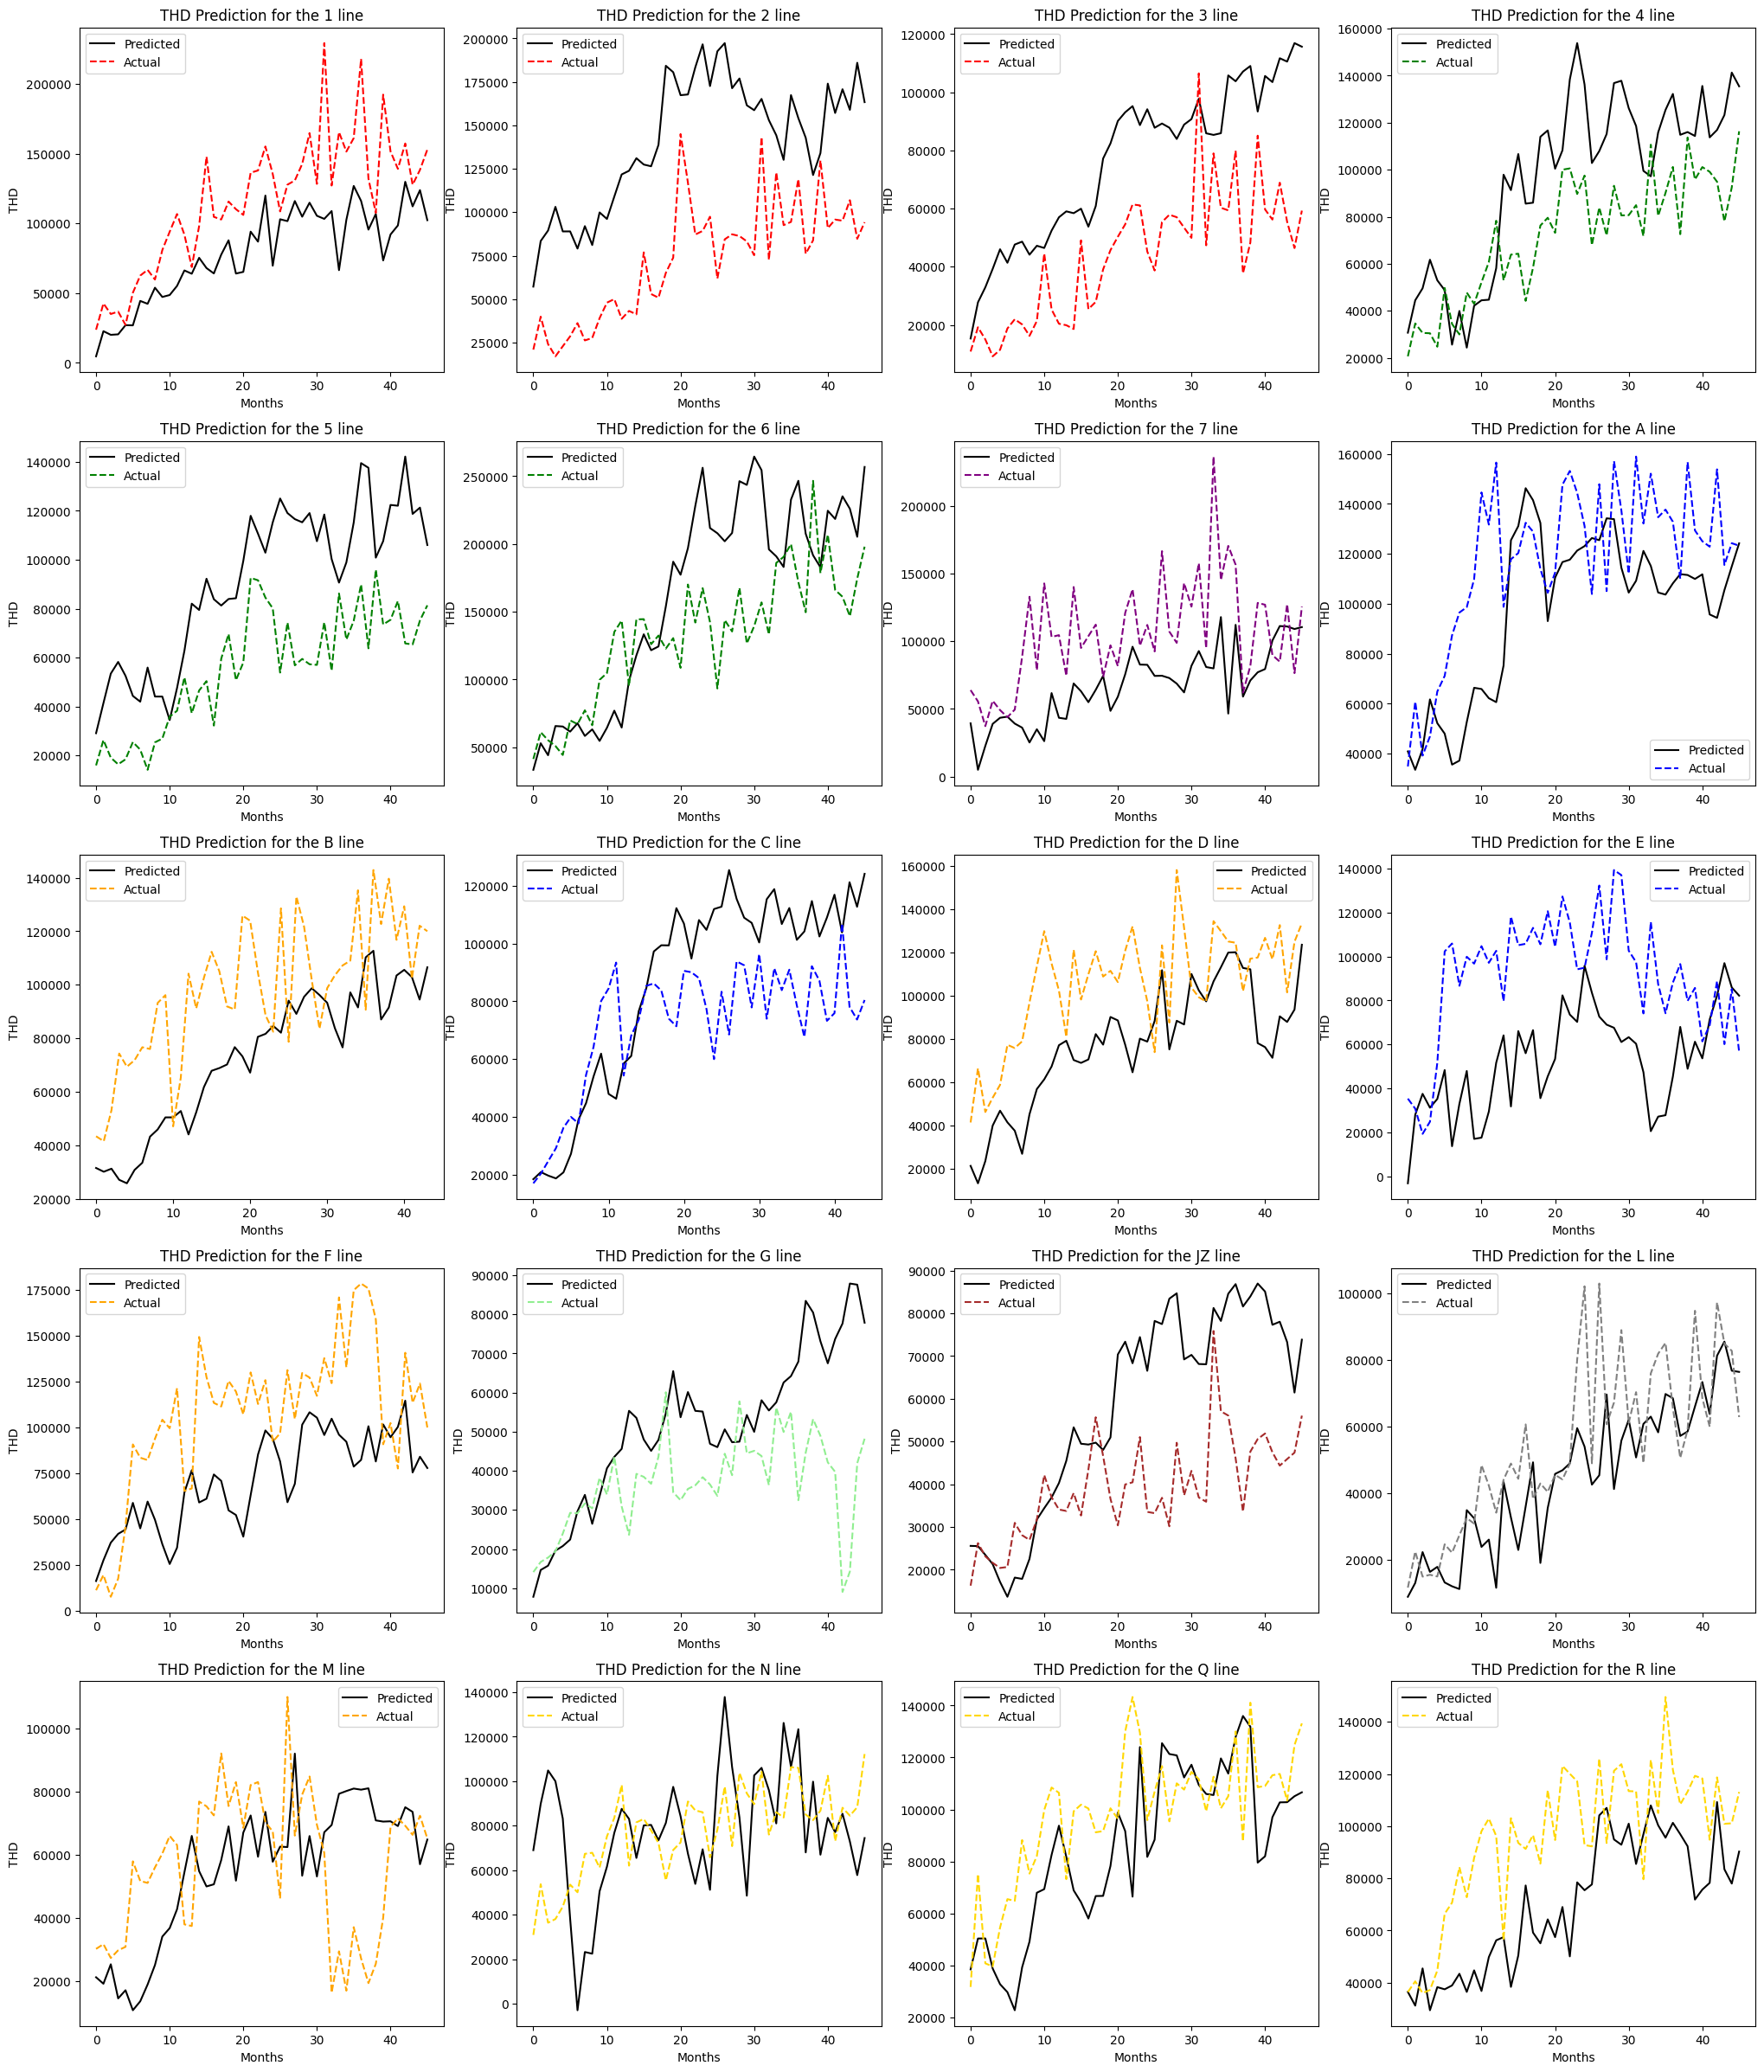

In [22]:
nrows = 5
ncols = 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 30))

for (key, value), i in zip(predictions.items(), range(num_lines)):
    ax_n = axs[i // ncols, i % ncols]
    ax_n.plot(value[0], label='Predicted', color="black")
    ax_n.plot(value[1], label='Actual', color=line_colors_shapes[key], linestyle='dashed')

    ax_n.set_title(f'THD Prediction for the {key} line')
    ax_n.set_ylabel("THD")
    ax_n.set_xlabel("Months")
    ax_n.legend()

plt.show()


In [8]:
def gru_model(df, line_to_test):
    print(f"Training line: {line_to_test}")
    X_train, X_test, y_train, y_test, scaler = split_df_by_line(df, line_to_test)

    # build the GRU model
    model = Sequential()

    model.add(GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))


    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model
    train_loss = model.evaluate(X_train, y_train)
    print(f"Train Loss: {train_loss}")

    test_loss = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}")

    # predict the delays for the line left for testing
    y_pred = model.predict(X_test)

    y_pred_scaled = scaler.inverse_transform(y_pred)
    y_test_scaled = scaler.inverse_transform(y_test)

    print(y_pred.reshape(-1))
    print(y_test.reshape(-1))

    return y_pred_scaled, y_test_scaled, 

In [18]:
lines_to_test = df['line'].unique()
num_lines = len(lines_to_test)

predictions = {}

for i, line_to_test in enumerate(lines_to_test):
    # predict the total hours delayed for the line
    y_pred_scaled, y_test_scaled = gru_model(df, line_to_test)
    predictions[line_to_test] = (y_pred_scaled, y_test_scaled)

Training line: 1
Epoch 1/32


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0489 - val_loss: 0.0214
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0215
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0272
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0206
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.0163
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_loss: 0.0224
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0159
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - val_loss: 0.0193
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0163
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0231
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0146
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - val_loss: 0.0219


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0274 - val_loss: 0.0175
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0111
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0267
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0196
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - val_loss: 0.0206
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0232
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0338
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 0.0308
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0419
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0279
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0515
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0401


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0442 - val_loss: 0.0102
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0069
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0094
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0105
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0119
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0109
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0094
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0165
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0093
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0102
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0101


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0531 - val_loss: 0.0090
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - val_loss: 0.0086
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0095
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0146
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0085
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0183
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_loss: 0.0130
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_loss: 0.0101
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0109
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0150
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0153
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0164


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0317 - val_loss: 0.0107
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0138
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0172
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0275
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0175
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0141
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0274
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0233
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0184
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0267
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0236


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0230 - val_loss: 0.0077
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0069
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0074
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0092
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0109
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0146
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0100
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0121
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0098
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - val_loss: 0.0126


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0153 - val_loss: 0.0284
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - val_loss: 0.0472
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_loss: 0.0383
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0434
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0323
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0356
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0402
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0352
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0262
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0418
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0477
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0409


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0576 - val_loss: 0.0055
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - val_loss: 0.0071
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - val_loss: 0.0082
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0133
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0095
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0113
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0202
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0226
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0156
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_loss: 0.0190
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0128
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0078


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0489 - val_loss: 0.0108
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_loss: 0.0115
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0126
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0112
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0105
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0082
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_loss: 0.0140
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0134
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0129
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0156
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0137


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0196 - val_loss: 0.0021
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0024
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0024
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0039
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - val_loss: 0.0058
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0029
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0031
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0072
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0033
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - val_loss: 0.0047


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0298 - val_loss: 0.0147
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0116
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0103
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.0080
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0066
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0119
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0109
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0120
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0103
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0099


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0487 - val_loss: 0.0245
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - val_loss: 0.0062
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0057
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0068
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0110
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0223
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.0254
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0188
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0156
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0208
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0188
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0196


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0424 - val_loss: 0.0123
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0231
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0260
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0369
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - val_loss: 0.0242
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0409
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0310
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0279
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0332
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0315
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0228
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0380


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0436 - val_loss: 0.0047
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0030
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - val_loss: 0.0039
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0036
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0043
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0048
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0033
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0042
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0027
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0032
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0045


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0421 - val_loss: 0.0136
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - val_loss: 0.0067
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0039
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0043
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0030
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0025
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0029
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0023
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0029
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0027


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0128 - val_loss: 0.0059
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0075
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0052
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0107
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0080
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - val_loss: 0.0051


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0252 - val_loss: 0.0068
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0052
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0062
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - val_loss: 0.0057
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0061
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0083
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0088
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0077
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0071


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0420 - val_loss: 0.0027
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0028
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0030
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0030
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0032
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0051
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0045
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0057
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0065


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0497 - val_loss: 0.0066
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.0059
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.0057
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104 - val_loss: 0.0061
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_loss: 0.0054
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0048
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0100
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0083
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0060
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0052


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0386 - val_loss: 0.0083
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_loss: 0.0129
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0095
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0096
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0144
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0099
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0116
Epoch 8/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0073
Epoch 9/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0168
Epoch 10/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0124
Epoch 11/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0105
Epoch 12/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0151


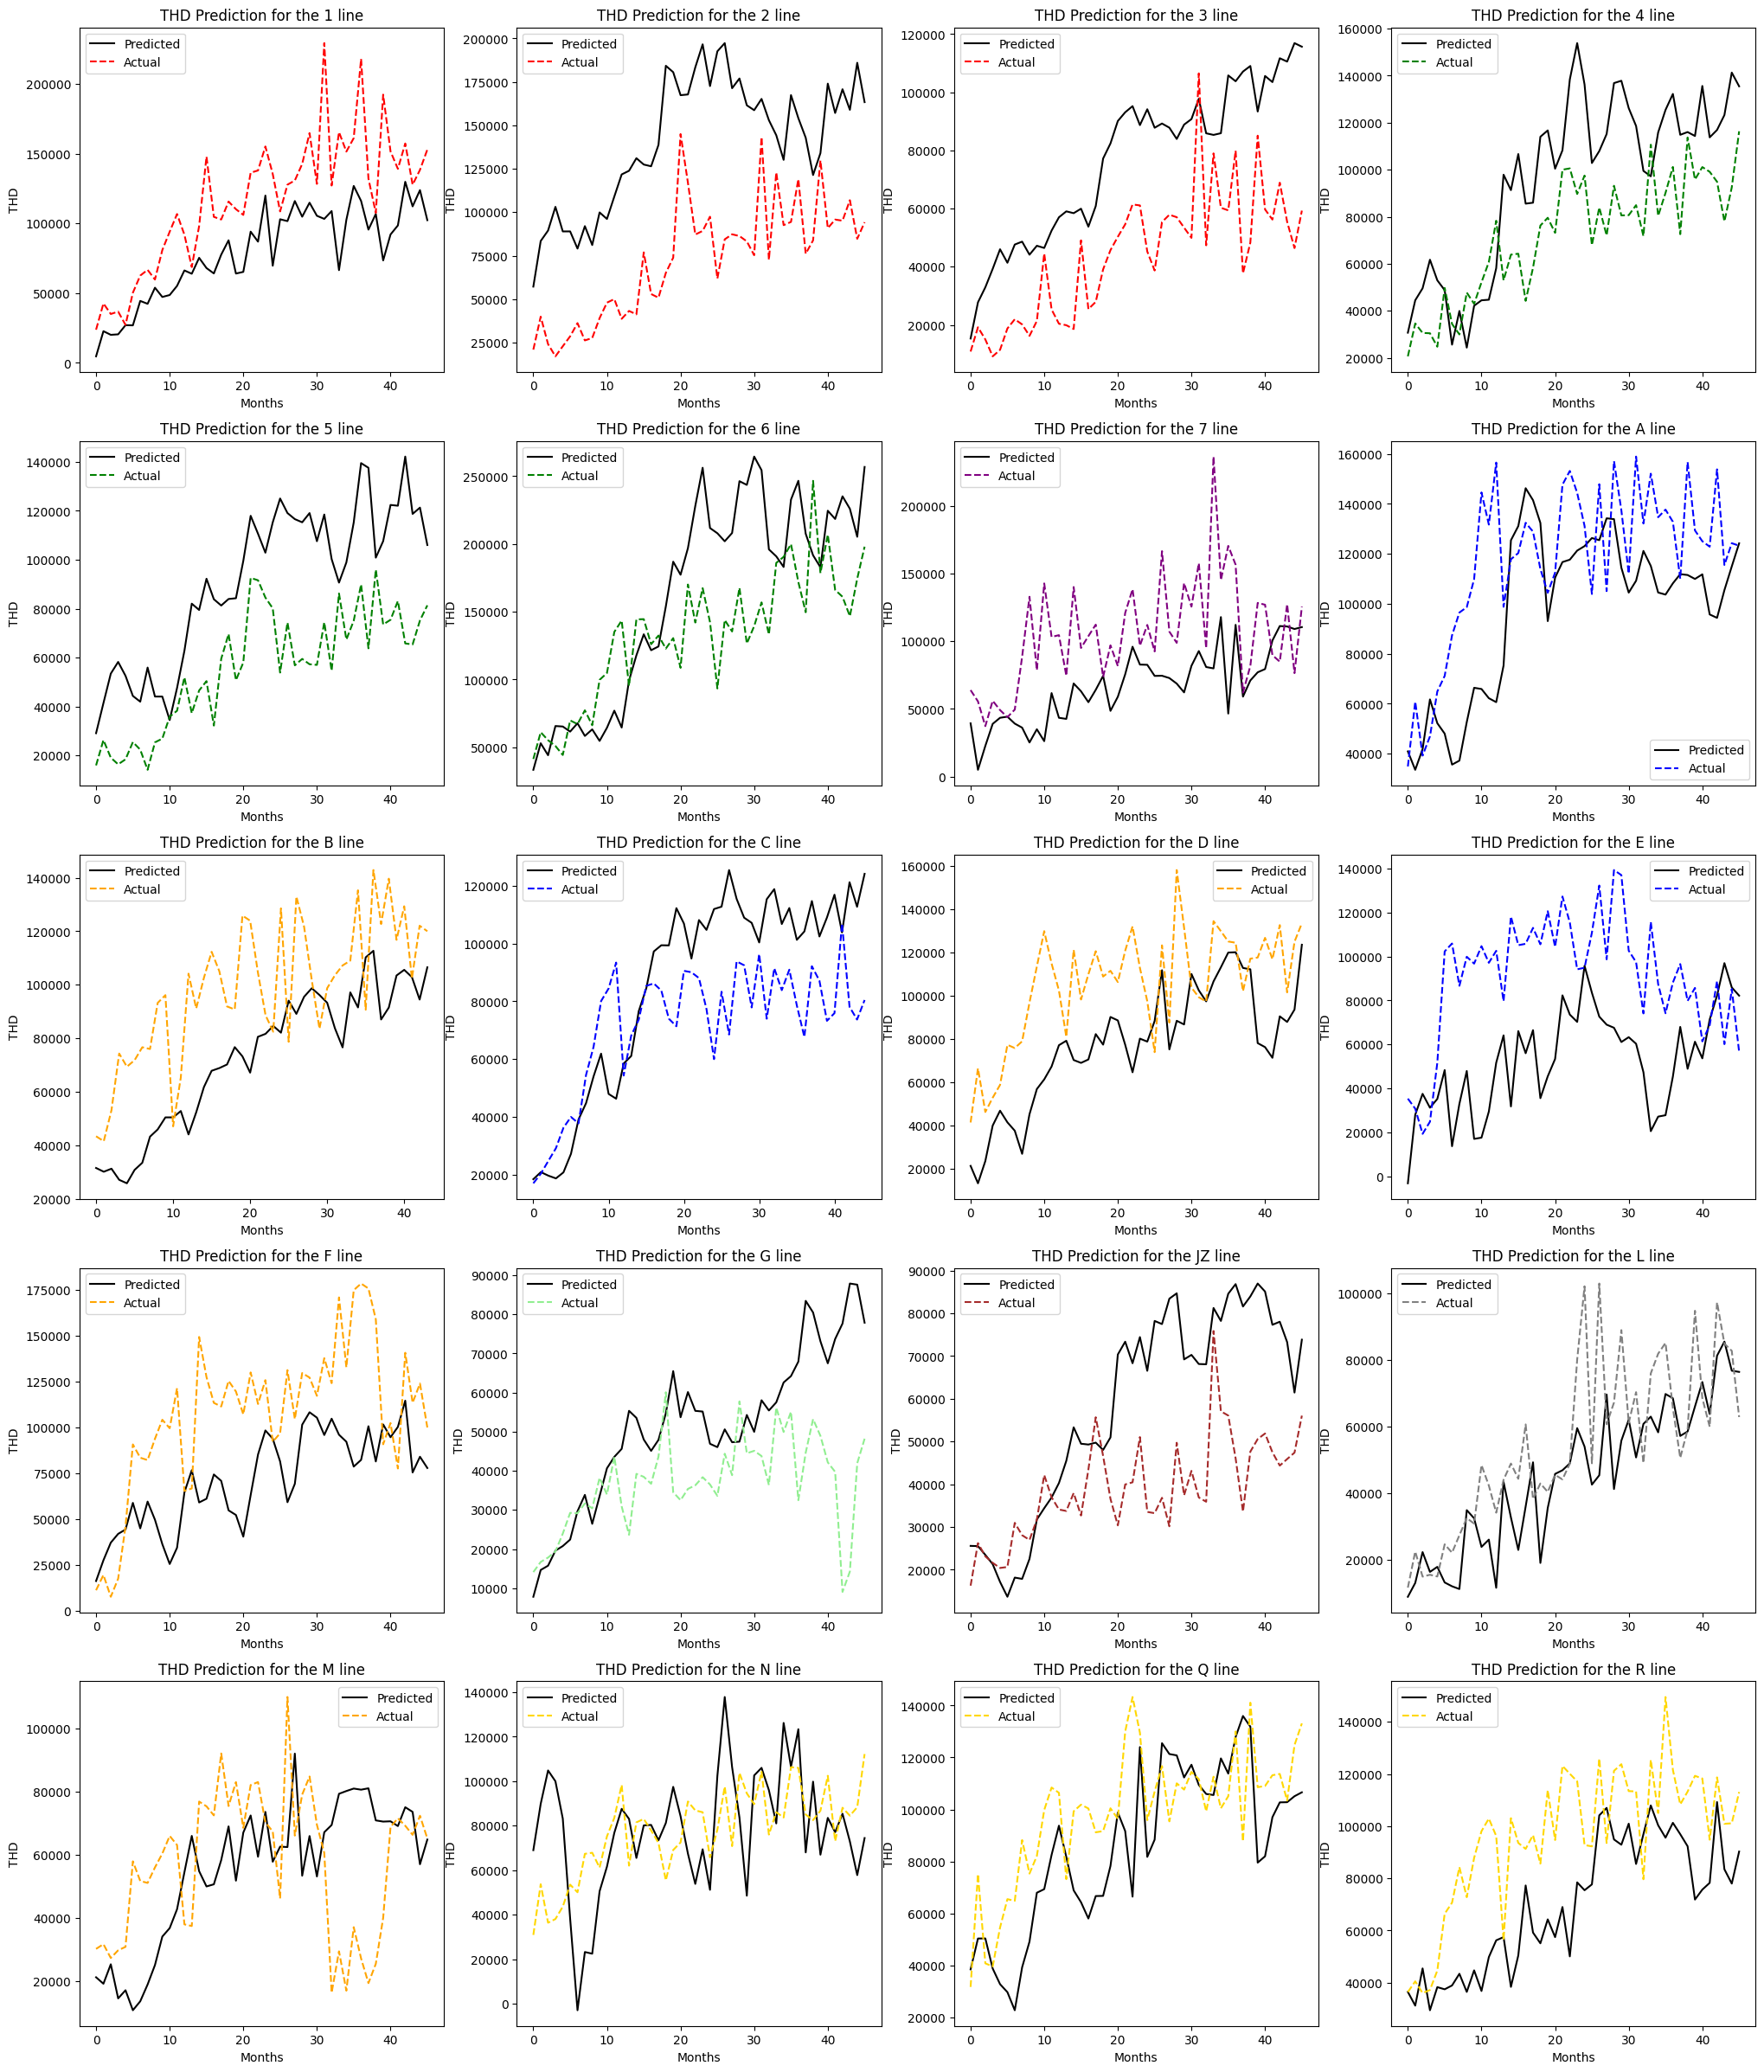

In [21]:
nrows = 5
ncols = 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 30))

for (key, value), i in zip(predictions.items(), range(num_lines)):
    ax_n = axs[i // ncols, i % ncols]
    ax_n.plot(value[0], label='Predicted', color="black")
    ax_n.plot(value[1], label='Actual', color=line_colors_shapes[key], linestyle='dashed')

    ax_n.set_title(f'THD Prediction for the {key} line')
    ax_n.set_ylabel("THD")
    ax_n.set_xlabel("Months")
    ax_n.legend()

plt.show()
